In [27]:
import keras
from keras.models import Model, load_model
from keras.layers import Dense
import keras.backend as K
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
%matplotlib inline
from shakespeare_utils import *

In [2]:
model, Tx, X, Y, x, y, chars, char_indices, indices_char = main()

Loading text data...
Creating training set...
number of training examples: 31412
Vectorizing training set...
Loading model...


/home/sudeep/.conda/envs/Keras2/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [3]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 40, 38)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 40, 128)           85504     
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 38)                4902      
_________________________________________________________________
activation_3 (Activation)    (None, 38)                0         
Total params: 221,990
Trainable params: 221,990
Non-trainable params: 0
_________________________________________________________________


In [5]:
generate_output(model, Tx, chars, char_indices, indices_char)

Write the beginning of your poem, the Shakespeare machine will complete it. Your input is: Let there be light


Here is your poem: 

Let there be light,
with painth no dost thos sigh thought,
who hour makes his hise own doth and thing,
and then sweet beauty of this mayy doth heart,
when fair which sand but deeplren's halk.

and sac for a lone of meming contest beart.

for my vey sesm il ssall thy beauty on the other dais,
against thy love beso that shall is sume,
and fleat that pant be my astering daye,
which i his begter mont be whe with doth s

In [15]:
def get_params():
    params = {}
    for i in range(1, 3):
        layer = model.layers[i]

        kernel, recurrent_kernel, bias = layer.get_weights()
        units = layer.units
        print("No. of units in LSTM layer" + str(i) + " " +str(units))

        kernel_i = kernel[:, :units]
        kernel_f = kernel[:, units: units * 2]
        kernel_c = kernel[:, units * 2: units * 3]
        kernel_o = kernel[:, units * 3:]

        recurrent_kernel_i = recurrent_kernel[:, :units]
        recurrent_kernel_f = recurrent_kernel[:, units: units * 2]
        recurrent_kernel_c = recurrent_kernel[:, units * 2: units * 3]
        recurrent_kernel_o = recurrent_kernel[:, units * 3:]

        bias_i = bias[:units]
        bias_f = bias[units: units * 2]
        bias_c = bias[units * 2: units * 3]
        bias_o = bias[units * 3:]


        params['layer'+str(i)] = {}
        params['layer'+str(i)]['kernel_i'] = kernel_i
        params['layer'+str(i)]['kernel_f'] = kernel_f
        params['layer'+str(i)]['kernel_c'] = kernel_c
        params['layer'+str(i)]['kernel_o'] = kernel_o
        params['layer'+str(i)]['recurrent_kernel_i'] = recurrent_kernel_i
        params['layer'+str(i)]['recurrent_kernel_f'] = recurrent_kernel_f
        params['layer'+str(i)]['recurrent_kernel_c'] = recurrent_kernel_c
        params['layer'+str(i)]['recurrent_kernel_o'] = recurrent_kernel_o
        params['layer'+str(i)]['bias_i'] = bias_i
        params['layer'+str(i)]['bias_f'] = bias_f
        params['layer'+str(i)]['bias_c'] = bias_c
        params['layer'+str(i)]['bias_o'] = bias_o
    return params

In [12]:
params = get_params()

No. of units in LSTM layer 1 128
No. of units in LSTM layer 2 128


In [18]:
print('Layer1 paramaters: ')
for key, value in params['layer1'].items():
    print("\t", key, value.shape)

print()

print('Layer2 paramaters: ')
for key, value in params['layer2'].items():
    print("\t", key, value.shape)

Layer1 paramaters: 
	 kernel_i (38, 128)
	 kernel_f (38, 128)
	 kernel_c (38, 128)
	 kernel_o (38, 128)
	 recurrent_kernel_i (128, 128)
	 recurrent_kernel_f (128, 128)
	 recurrent_kernel_c (128, 128)
	 recurrent_kernel_o (128, 128)
	 bias_i (128,)
	 bias_f (128,)
	 bias_c (128,)
	 bias_o (128,)

Layer2 paramaters: 
	 kernel_i (128, 128)
	 kernel_f (128, 128)
	 kernel_c (128, 128)
	 kernel_o (128, 128)
	 recurrent_kernel_i (128, 128)
	 recurrent_kernel_f (128, 128)
	 recurrent_kernel_c (128, 128)
	 recurrent_kernel_o (128, 128)
	 bias_i (128,)
	 bias_f (128,)
	 bias_c (128,)
	 bias_o (128,)


In [19]:
def hard_sigmoid(x):
    return np.maximum(np.minimum(x*0.2 + 0.5, 1), 0)

In [20]:
def get_intermediate_outputs(layer, inputs, h1_tm1, c1_tm1, h2_tm1, c2_tm1, params, activation=np.tanh, recurrent_activation=hard_sigmoid):
    if layer not in {"layer1", "layer2"}:
        print("Layer has to be layer1 or layer2")
        return
    else:
        p = params["layer1"]
        h_tm1 = h1_tm1
        c_tm1 = c1_tm1
        x_i = np.dot(inputs, p['kernel_i']) + p['bias_i']
        x_f = np.dot(inputs, p['kernel_f']) + p['bias_f']
        x_c = np.dot(inputs, p['kernel_c']) + p['bias_c']
        x_o = np.dot(inputs, p['kernel_o']) + p['bias_o']
        
        i = recurrent_activation(x_i + np.dot(h_tm1, p['recurrent_kernel_i']))
        f = recurrent_activation(x_f + np.dot(h_tm1, p['recurrent_kernel_f']))
        c = f * c_tm1 + i * activation(x_c + np.dot(h_tm1,p['recurrent_kernel_c']))
        o = recurrent_activation(x_o + np.dot(h_tm1, p['recurrent_kernel_o']))
        
        h = o * activation(c)
        if layer == "layer1":
            return h, i, f, c, o
        else:
            p = params["layer2"]
            
            h_tm1 = h2_tm1
            c_tm1 = c2_tm1
            
            x_i = np.dot(h, p['kernel_i']) + p['bias_i']
            x_f = np.dot(h, p['kernel_f']) + p['bias_f']
            x_c = np.dot(h, p['kernel_c']) + p['bias_c']
            x_o = np.dot(h, p['kernel_o']) + p['bias_o']

            I = recurrent_activation(x_i + np.dot(h_tm1, p['recurrent_kernel_i']))
            F = recurrent_activation(x_f + np.dot(h_tm1, p['recurrent_kernel_f']))
            C = F * c_tm1 + I * activation(x_c + np.dot(h_tm1,p['recurrent_kernel_c']))
            O = recurrent_activation(x_o + np.dot(h_tm1, p['recurrent_kernel_o']))

            H = O * activation(C)
            return H, I, F, C, O, h, i, f, c, o

In [21]:
def one_pass_through_time(inputs, params):
    m, Tx, d = inputs.shape
    
    ht = np.zeros((m, 128)) #  h1_tm1
    Ht = np.zeros((m, 128)) #  h2_tm1
    ct = np.zeros_like(ht)  #  c1_tm1
    Ct = np.zeros_like(Ht)  #  c2_tm1
    
    h = np.zeros((m, Tx, 128)) #All times
    i, f, c, o = np.zeros_like(h), np.zeros_like(h), np.zeros_like(h), np.zeros_like(h)
    
    H = np.zeros((m, Tx, 128)) #All times
    I, F, C, O = np.zeros_like(H), np.zeros_like(H), np.zeros_like(H), np.zeros_like(H)
    
    for t in range(Tx):
        Ht, It, Ft, Ct, Ot, ht, it, ft, ct, ot = get_intermediate_outputs("layer2", inputs[:, t, :], ht, Ct, Ht, Ct, params)
        h[:, t, :] = ht
        i[:, t, :] = it
        f[:, t, :] = ft
        c[:, t, :] = ct
        o[:, t, :] = ot
        H[:, t, :] = Ht
        I[:, t, :] = It
        F[:, t, :] = Ft
        C[:, t, :] = Ct
        O[:, t, :] = Ot
    
    return H, I, F, C, O, h, i, f, c, o

In [22]:
index = 14
print(X[index])
print(Y[index])
H, I, F, C, O, h, i, f, c, o = one_pass_through_time(x[index:index+1], params)

fairest creatures we desire increase,
th
a


In [23]:
C.shape

(1, 40, 128)

In [24]:
def transform(C, I, F, n_components=5, mode="random"):
    if mode == "random":
        nodes = np.random.randint(C.shape[1], size=n_components)
        print("Using nodes: " + str(nodes))
        
        C_tr = np.array([C[:, node] for node in nodes]).T
        I_tr = np.array([I[:, node] for node in nodes]).T
        F_tr = np.array([F[:, node] for node in nodes]).T
        
        assert(C_tr.shape == (C.shape[0], n_components))

    else:
        print("Using PCA ")
        pca = PCA(n_components)
        pca.fit(C)
        
        C_tr = pca.transform(C)
        I_tr = pca.transform(I)
        F_tr = pca.transform(F)
        nodes = ['Component 0', 'Component 1', 'Component 2', 'Component 3', 'Component 4']
    return C_tr, I_tr, F_tr, nodes

In [25]:
C_tr, I_tr, F_tr, nodes = transform(C[0], I[0], F[0], mode="random")

Using nodes: [44 48 86 32 49]


In [30]:
def plot(C_tr, F_tr, I_tr, t, y_labels, x_labels):
    plt.rcdefaults()
    fig, ax = plt.subplots(3, t, sharex='all', sharey='row', figsize=(2*t, 4))
    fig.suptitle("CELL STATE, UPDATE GATE and FORGET GATE across Time", fontsize=12)
    y_pos = np.arange(len(y_labels))

    ax[0, 0].set_ylabel("Cell State")
    ax[1, 0].set_ylabel("Update Gate")
    ax[2, 0].set_ylabel("Forget Gate")
    for i in range(t):

        ax[0, i].barh(y_pos, C_tr[i], align='center',
                color='green')
        ax[0, i].set_yticks(y_pos)
        ax[0, i].set_yticklabels(y_labels)
        ax[0, i].invert_yaxis()  # labels read top-to-bottom

        ax[1, i].barh(y_pos, I_tr[i], align='center',
                color='blue', label='I')
        ax[1, i].set_yticks(y_pos)
        ax[1, i].set_yticklabels(y_labels)
        ax[1, i].invert_yaxis()  # labels read top-to-bottom

        ax[2, i].barh(y_pos, F_tr[i], align='center',
                color='red', label='F')
        ax[2, i].set_yticks(y_pos)
        ax[2, i].set_yticklabels(y_labels)
        ax[2, i].invert_yaxis()  # labels read top-to-bottom
        ax[2, i].set_xlabel(x_labels[i])

    plt.show()

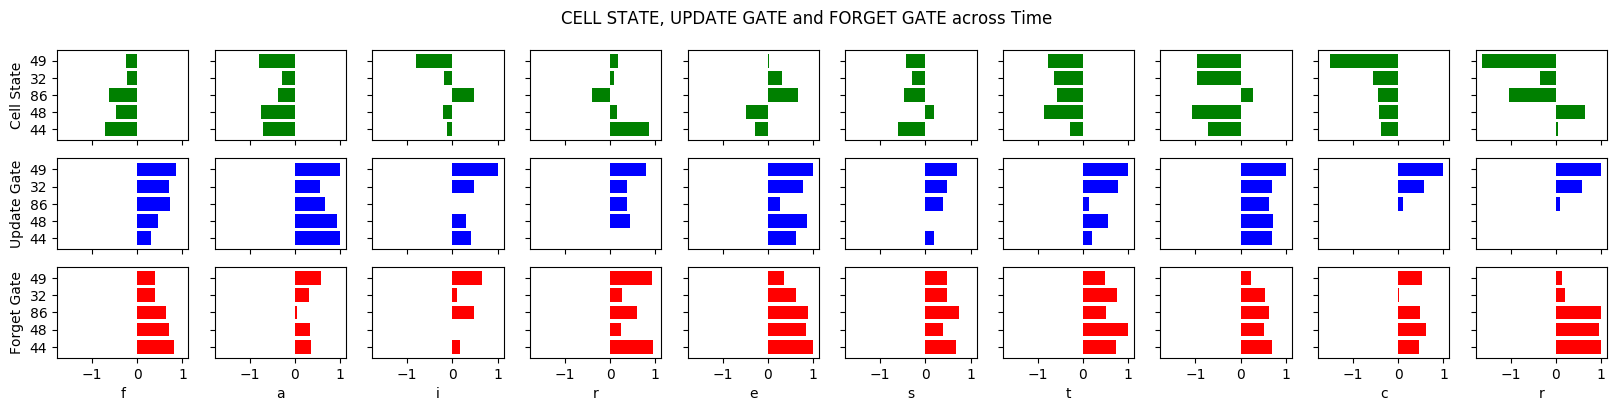

In [31]:
plot(C_tr, I_tr, F_tr, 10, nodes, X[index])